# Revisiting Lambert's problem in Python

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

from poliastro.iod import izzo

plt.rc('text', usetex=True)

## Part 1: Reproducing the original figure

In [2]:
x = np.linspace(-1, 2, num=1000)
M_list = 0, 1, 2, 3
ll_list = 1, 0.9, 0.7, 0, -0.7, -0.9, -1

<IPython.core.display.Javascript object>


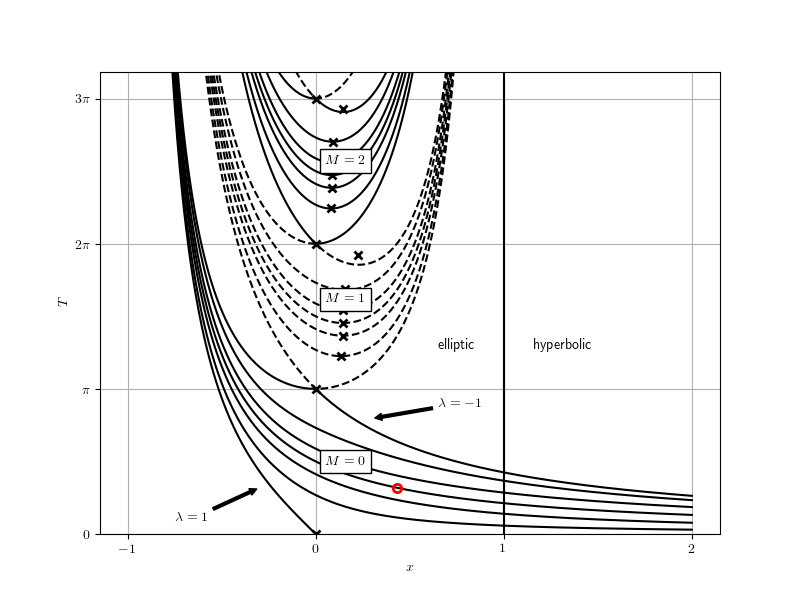

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_prop_cycle(cycler('linestyle', ['-', '--']) *
                  (cycler('color', ['black']) * len(ll_list)))
for M in M_list:
    for ll in ll_list:
        T_x0 = np.zeros_like(x)
        for ii in range(len(x)):
            y = izzo._compute_y(x[ii], ll)
            T_x0[ii] = izzo._tof_equation(x[ii], y, 0.0, ll, M)
        if M == 0 and ll == 1:
            T_x0[x > 0] = np.nan
        elif M > 0:
            # Mask meaningless solutions
            T_x0[x > 1] = np.nan
        l, = ax.plot(x, T_x0)

ax.set_ylim(0, 10)

ax.set_xticks((-1, 0, 1, 2))
ax.set_yticks((0, np.pi, 2 * np.pi, 3 * np.pi))
ax.set_yticklabels(('$0$', '$\pi$', '$2 \pi$', '$3 \pi$'))

ax.vlines(1, 0, 10)
ax.text(0.65, 4.0, "elliptic")
ax.text(1.16, 4.0, "hyperbolic")

ax.text(0.05, 1.5, "$M = 0$", bbox=dict(facecolor='white'))
ax.text(0.05, 5, "$M = 1$", bbox=dict(facecolor='white'))
ax.text(0.05, 8, "$M = 2$", bbox=dict(facecolor='white'))

ax.annotate("$\lambda = 1$", xy=(-0.3, 1), xytext=(-0.75, 0.25), arrowprops=dict(arrowstyle="simple", facecolor="black"))
ax.annotate("$\lambda = -1$", xy=(0.3, 2.5), xytext=(0.65, 2.75), arrowprops=dict(arrowstyle="simple", facecolor="black"))

ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$T$")

## Part 2: Locating $T_{min}$

In [4]:
for M in M_list:
    for ll in ll_list:
        x_T_min, T_min = izzo._compute_T_min(ll, M, 10, 1e-8)
        ax.plot(x_T_min, T_min, 'kx', mew=2)

## Part 3: Try out solution

In [5]:
T_ref = 1
ll_ref = 0

(x_ref, _), = izzo._find_xy(ll_ref, T_ref, 0, 10, 1e-8)
x_ref

0.43344673453504257

In [6]:
ax.plot(x_ref, T_ref, 'o', mew=2, mec='red', mfc='none')

## Part 4: Run some examples

In [7]:
from astropy import units as u

from poliastro.bodies import Earth

### Single revolution

In [8]:
k = Earth.k
r0 = [15945.34, 0.0, 0.0] * u.km
r = [12214.83399, 10249.46731, 0.0] * u.km
tof = 76.0 * u.min

expected_va = [2.058925, 2.915956, 0.0] * u.km / u.s
expected_vb = [-3.451569, 0.910301, 0.0] * u.km / u.s

(v0, v), = izzo.lambert(k, r0, r, tof)
v

<Quantity [-3.4515665 , 0.91031354, 0.        ] km / s>

In [9]:
k = Earth.k
r0 = [5000.0, 10000.0, 2100.0] * u.km
r = [-14600.0, 2500.0, 7000.0] * u.km
tof = 1.0 * u.h

expected_va = [-5.9925, 1.9254, 3.2456] * u.km / u.s
expected_vb = [-3.3125, -4.1966, -0.38529] * u.km / u.s

(v0, v), = izzo.lambert(k, r0, r, tof)
v

<Quantity [-3.3124585 ,-4.19661901,-0.38528906] km / s>

### Multiple revolutions

In [10]:
k = Earth.k
r0 = [22592.145603, -1599.915239, -19783.950506] * u.km
r = [1922.067697, 4054.157051, -8925.727465] * u.km
tof = 10 * u.h

expected_va = [2.000652697, 0.387688615, -2.666947760] * u.km / u.s
expected_vb = [-3.79246619, -1.77707641, 6.856814395] * u.km / u.s

expected_va_l = [0.50335770, 0.61869408, -1.57176904] * u.km / u.s
expected_vb_l = [-4.18334626, -1.13262727, 6.13307091] * u.km / u.s

expected_va_r = [-2.45759553, 1.16945801, 0.43161258] * u.km / u.s
expected_vb_r = [-5.53841370, 0.01822220, 5.49641054] * u.km / u.s

In [11]:
(v0, v), = izzo.lambert(k, r0, r, tof, M=0)
v

<Quantity [-3.79246619,-1.77707641, 6.85681439] km / s>

In [12]:
(_, v_l), (_, v_r) = izzo.lambert(k, r0, r, tof, M=1)

In [13]:
v_l

<Quantity [-4.18334626,-1.13262727, 6.13307091] km / s>

In [14]:
v_r

<Quantity [-5.53841318, 0.01822213, 5.49641016] km / s>

In [15]:
fig.savefig("lambert.png")